In [25]:
from IPython.display import Image

LangChain => LangGraph

- LangChain 的链（Chain）不具备“循环”能力；
- AgentExecutor 调度的Agent运行过于“黑盒”。
    - llm with tool executor

LangGraph vs. AutoGen

- 都是 Multi-agent framework
- LangGraph prefers an approach where you explicitly define different agents and transition probabilities, preferring to represent it as a graph
- Autogen frames it more as a "conversation". 
- Another key difference between Autogen and LangGraph is that LangGraph is fully integrated into the LangChain ecosystem, meaning you take fully advantage of all the LangChain integrations and LangSmith observability.


## (Self-Corrective) RAG on LangGraph

https://github.com/vbarda/pandas-rag-langgraph/blob/main/demo.ipynb

- RAG（Retrieval-Augmented Generation）
    - 未被 llm 训练过程覆盖的 domain knowledge 或者新知识；
    - 提供确定性的知识作为 context，进一步降低幻觉（hallucinations）
        - GROUNDED IN DOCUMENTS
- vector database
    - Chroma

#### RAG chain: developer-defined control flow

In [26]:
Image(url='../../../imgs/rag-chain.png', width=500)

#### RAG Agent: LLM-defined control flow

In [27]:
Image(url='../../../imgs/rag-agent.png', width=500)

#### Self-Corrective RAG 

In [28]:
Image(url='../../../imgs/self-corrective-rag.png', width=500)

In [1]:
# !pip install langgraph-checkpoint-sqlite
# !pip install beautifulsoup4
# !pip install chromadb

In [2]:
import re
from typing import Annotated, Iterator, Literal, TypedDict

from langchain import hub

# llm
# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

# tool, 
# https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/
# TAVILY_API_KEY
from langchain_community.tools.tavily_search import TavilySearchResults

# rag
from langchain_community.document_loaders import web_base
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_core.retrievers import BaseRetriever

# messages & prompts
from langchain_core.messages import BaseMessage, AIMessage, convert_to_messages
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_text_splitters import RecursiveCharacterTextSplitter

# langgraph
from langgraph.graph import END, StateGraph, add_messages

from langgraph.checkpoint.memory import MemorySaver

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'
from dotenv import load_dotenv
load_dotenv()

True

## model, retriever & tools

In [4]:
SOURCE_URLS = [
    'https://pandas.pydata.org/docs/user_guide/indexing.html',
    'https://pandas.pydata.org/docs/user_guide/groupby.html',
    'https://pandas.pydata.org/docs/user_guide/merging.html'
]
NEWLINE_RE = re.compile("\n+")


In [5]:
class PandasDocsLoader(web_base.WebBaseLoader):
    def lazy_load(self) -> Iterator[Document]:
        """Lazy load text from the url(s) in web_path."""
        for path in self.web_paths:
            soup = self._scrape(path, bs_kwargs=self.bs_kwargs)
            text = soup.get_text(**self.bs_get_text_kwargs)
            text = NEWLINE_RE.sub("\n", text)     
            metadata = web_base._build_metadata(soup, path)
            yield Document(page_content=text, metadata=metadata)

In [6]:
PandasDocsLoader(SOURCE_URLS).web_paths

['https://pandas.pydata.org/docs/user_guide/indexing.html',
 'https://pandas.pydata.org/docs/user_guide/groupby.html',
 'https://pandas.pydata.org/docs/user_guide/merging.html']

In [7]:
def prepare_documents(urls: list[str]) -> list[Document]:
    text_splitter = RecursiveCharacterTextSplitter(
        separators=[
            r"In \[[0-9]+\]",
            r"\n+",
            r"\s+"
        ],
        is_separator_regex=True,
        chunk_size=1000
    )
    docs = [PandasDocsLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]
    return text_splitter.split_documents(docs_list)

In [8]:
def get_retriever() -> BaseRetriever:
    documents = prepare_documents(SOURCE_URLS)
    vectorstore = Chroma.from_documents(
        documents=documents,
        collection_name="pandas-rag-chroma",
        embedding=OpenAIEmbeddings(),
    )
    retriever = vectorstore.as_retriever()
    return retriever

In [9]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)
retriever = get_retriever()
tavily_search_tool = TavilySearchResults(max_results=3)

## Graph

In [43]:
Image(url='../../../imgs/self-corrective-rag.png', width=500)

- state: graph 中所有 node 的输入
    - question: user query
    - messages: add
    - documents: 基于 `retriever.invoke(question)` or `search_tool`
    - candidate_answer: generate
    - retries
    - web_fallback
- nodes: 接收状态，执行动作，产生/改变状态
    - rewrite question: 单独的一个重写用户 query 的 llm 调用
    - document_search: retriever
        - append documents
    - generate: llm chain (lcel)
        - 提供或者替换 candidate_answer
    - web search: search tool
        - append documents
    - finalize response

### state

In [10]:
class GraphState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    question: str
    documents: list[Document]
    candidate_answer: str
    retries: int
    web_fallback: bool


class GraphConfig(TypedDict):
    max_retries: int

In [15]:
MAX_RETRIES = 3
VERBOSE = True

### nodes

#### document search node

In [16]:
def document_search(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if VERBOSE:
        print("---RETRIEVE---")

    question = convert_to_messages(state["messages"])[-1].content

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "web_fallback": True}

In [18]:
# https://smith.langchain.com/hub/rlm/rag-prompt
# RAG: QA with context, answer the question base the context
RAG_PROMPT: ChatPromptTemplate = hub.pull("rlm/rag-prompt")
RAG_PROMPT

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

#### generate node

In [19]:
def generate(state: GraphState):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if VERBOSE:
        print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    retries = state["retries"] if state.get("retries") is not None else -1

    # lcel
    rag_chain = RAG_PROMPT | llm | StrOutputParser()
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"retries": retries + 1, "candidate_answer": generation}

#### rewrite question

In [20]:
QUERY_REWRITER_SYSTEM = (
"""
You are a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
Look at the input and try to reason about the underlying semantic intent / meaning.
"""
)

QUERY_REWRITER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", QUERY_REWRITER_SYSTEM),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [21]:
def transform_query(state: GraphState):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    if VERBOSE:
        print("---TRANSFORM QUERY---")

    question = state["question"]

    # Re-write question
    query_rewriter = QUERY_REWRITER_PROMPT | llm | StrOutputParser()
    better_question = query_rewriter.invoke({"question": question})
    return {"question": better_question}

#### web search

In [22]:
def web_search(state: GraphState):
    if VERBOSE:
        print("---RUNNING WEB SEARCH---")

    question = state["question"]
    documents = state["documents"]
    search_results = tavily_search_tool.invoke(question)
    search_content = "\n".join([d["content"] for d in search_results])
    documents.append(Document(page_content=search_content, metadata={"source": "websearch"}))
    return {"documents": documents, "web_fallback": False}

#### finalize resp

In [23]:
def finalize_response(state: GraphState):
    if VERBOSE:
        print("---FINALIZING THE RESPONSE---")

    return {"messages": [AIMessage(content=state["candidate_answer"])]}

### edges & graph

In [42]:
Image(url='../../../imgs/self-corrective-rag.png', width=500)

#### Grade answer

- Check hallucinations
- Check answer relevance

In [29]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


HALLUCINATION_GRADER_SYSTEM = (
"""
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no', where 'yes' means that the answer is grounded in / supported by the set of facts.

IF the generation includes code examples, make sure those examples are FULLY present in the set of facts, otherwise always return score 'no'.
"""
)

HALLUCINATION_GRADER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", HALLUCINATION_GRADER_SYSTEM),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)


class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


ANSWER_GRADER_SYSTEM = (
"""
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no', where 'yes' means that the answer resolves the question.
"""
)

ANSWER_GRADER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", ANSWER_GRADER_SYSTEM),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [30]:
def grade_generation_v_documents_and_question(state: GraphState, config) -> Literal["generate", "transform_query", "web_search", "finalize_response"]:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["candidate_answer"]
    web_fallback = state["web_fallback"]
    retries = state["retries"] if state.get("retries") is not None else -1
    max_retries = config.get("configurable", {}).get("max_retries", MAX_RETRIES)

    # this means we've already gone through web fallback and can return to the user
    if not web_fallback:
        return "finalize_response"

    if VERBOSE:
        print("---CHECK HALLUCINATIONS---")

    # llm lcel chain
    hallucination_grader = HALLUCINATION_GRADER_PROMPT | llm.with_structured_output(GradeHallucinations)
    hallucination_grade: GradeHallucinations = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    # Check hallucination
    if hallucination_grade.binary_score == "no":
        if VERBOSE: print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "generate" if retries < max_retries else "web_search"

    if VERBOSE:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")

    # Check question-answering
    answer_grader = ANSWER_GRADER_PROMPT | llm.with_structured_output(GradeAnswer)
    answer_grade: GradeAnswer = answer_grader.invoke({"question": question, "generation": generation})
    if answer_grade.binary_score == "yes":
        if VERBOSE: print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "finalize_response"
    else:
        if VERBOSE: print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "transform_query" if retries < max_retries else "web_search"

条件性跳转（from `generate`），基于的幻觉检测（llm lcel chain invoke）
- "generate",
- "transform_query",
- "web_search",
- "finalize_response"

#### build the graph

In [31]:
workflow = StateGraph(GraphState, config_schema=GraphConfig)

# Define the nodes
workflow.add_node("document_search", document_search)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)
workflow.add_node("finalize_response", finalize_response)

# Build graph
workflow.set_entry_point("document_search")
workflow.add_edge("document_search", "generate")
workflow.add_edge("transform_query", "document_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("finalize_response", END)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question
)

# Compile
graph = workflow.compile()

In [35]:
from IPython.display import Image, display

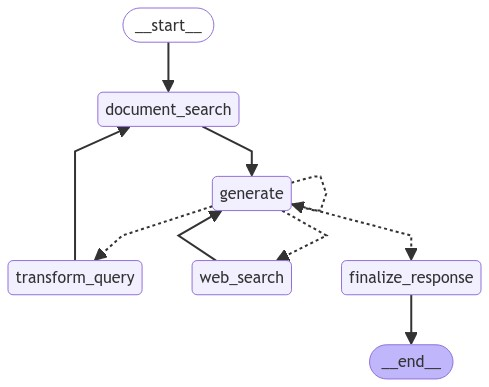

In [36]:
# grade_generation_v_documents_and_question
display(Image(graph.get_graph().draw_mermaid_png()))

### run the graph

In [38]:
VERBOSE = True
inputs = {"messages": [("human", "how do i calculate sum by groups")]}
for output in graph.stream(inputs):
    print(output)
    print("\n---\n")

---RETRIEVE---
{'document_search': {'question': 'how do i calculate sum by groups', 'documents': [Document(metadata={'language': 'en', 'source': 'https://pandas.pydata.org/docs/user_guide/groupby.html', 'title': 'Group by: split-apply-combine — pandas 2.2.2 documentation'}, page_content='Windowing operations\nTime series / date functionality\nTime deltas\nOptions and settings\nEnhancing performance\nScaling to large datasets\nSparse data structures\nFrequently Asked Questions (FAQ)\nCookbook\nUser Guide\nGroup by:...\nGroup by: split-apply-combine#\nBy “group by” we are referring to a process involving one or more of the following\nsteps:\nSplitting the data into groups based on some criteria.\nApplying a function to each group independently.\nCombining the results into a data structure.\nOut of these, the split step is the most straightforward. In the apply step, we\nmight wish to do one of the following:\nAggregation: compute a summary statistic (or statistics) for each\ngroup. Some 

#### Query with a fallback

In [40]:
VERBOSE = True
inputs = {"messages": [("human", "how do i convert a column into dummies")]}
for output in graph.stream(inputs, {"configurable": {"max_retries": 1}}):
    print(output)
    print("\n---\n")

---RETRIEVE---
{'document_search': {'question': 'how do i convert a column into dummies', 'documents': [Document(metadata={'language': 'en', 'source': 'https://pandas.pydata.org/docs/user_guide/indexing.html', 'title': 'Indexing and selecting data — pandas 2.2.2 documentation'}, page_content="In [7]: df[['B', 'A']] = df[['A', 'B']]\nIn [8]: df\nOut[8]: \n                   A         B         C         D\n2000-01-01 -0.282863  0.469112 -1.509059 -1.135632\n2000-01-02 -0.173215  1.212112  0.119209 -1.044236\n2000-01-03 -2.104569 -0.861849 -0.494929  1.071804\n2000-01-04 -0.706771  0.721555 -1.039575  0.271860\n2000-01-05  0.567020 -0.424972  0.276232 -1.087401\n2000-01-06  0.113648 -0.673690 -1.478427  0.524988\n2000-01-07  0.577046  0.404705 -1.715002 -1.039268\n2000-01-08 -1.157892 -0.370647 -1.344312  0.844885\nYou may find this useful for applying a transform (in-place) to a subset of the\ncolumns.\nWarning\npandas aligns all AXES when setting Series and DataFrame from .loc.\nThis w

In [41]:
graph.invoke(inputs)

---RETRIEVE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---RUNNING WEB SEARCH---
---GENERATE---
---FINALIZING THE RESPONSE---


{'messages': [HumanMessage(content='how do i convert a column into dummies', id='69125d7d-3b0e-42d7-8192-d43fd71ef25f'),
  AIMessage(content="You can convert a column into dummies using the `pd.get_dummies` function in pandas. For example, `pd.get_dummies(df['column_name'])` will create dummy variables for the specified column. If you want to include the original DataFrame, you can use `pd.get_dummies(df, columns=['column_name'])`.", id='c199ec88-cc3c-494d-adeb-3c7290bfe4b6')],
 'question': 'how do i convert a column into dummies',
 'documents': [Document(metadata={'language': 'en', 'source': 'https://pandas.pydata.org/docs/user_guide/indexing.html', 'title': 'Indexing and selecting data — pandas 2.2.2 documentation'}, page_content="In [7]: df[['B', 'A']] = df[['A', 'B']]\nIn [8]: df\nOut[8]: \n                   A         B         C         D\n2000-01-01 -0.282863  0.469112 -1.509059 -1.135632\n2000-01-02 -0.173215  1.212112  0.119209 -1.044236\n2000-01-03 -2.104569 -0.861849 -0.4949